In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

X_train = np.loadtxt("Dataset/train/X_train.txt")
y_train = np.loadtxt("Dataset/train/y_train.txt")

X_test = np.loadtxt("Dataset/test/X_test.txt")
y_test = np.loadtxt("Dataset/test/y_test.txt")

p = X_train.shape[1]
N = X_train.shape[0]

def standardize(X_train, X_test):
    mu = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    
    X_train = (X_train - mu)/std
    X_test = (X_test - mu)/std
    
    return X_train, X_test

X_train, X_test = standardize(X_train, X_test)


def get_cov(X):
    N = X.shape[0]
    p = X.shape[1]
    
    mu = np.mean(X, axis=0)
    
    Sigma = np.zeros([p,p])
    
    for x in X:
        Sigma = Sigma + np.outer(x-mu, x-mu)
    
    Sigma = Sigma / (N - 1)
    return Sigma
    
def get_pooled_cov(X_train, y_train, class_labels):
    
    N = X_train.shape[0]
    p = X_train.shape[1]
    
    K = len(class_labels)
    
    Sigma = np.zeros([p,p])
    
    for k in range(0, K):
        # Get n for class k
        index_k =  [i for i in range(0,N) if y_train[i] == class_labels[k]]
        n_k = len(index_k)
        
        Sigma = Sigma + get_cov(X_train[index_k,:]) * (n_k - 1)
        
    Sigma = Sigma / (N - K)
    return Sigma

def LDA(X_train, y_train, X_test, y_test, regularisation = 0):
    N = X_train.shape[0] # Number of measurements
    N_test = X_test.shape[0]
    p = X_train.shape[1] # Number of different features
    
    class_labels = np.unique(y_train)
    K = len(class_labels) # K : number of different classes

    # Get the diffrent mu's        
    mu = np.zeros([p, K]) # K different mu's in p dimensions
    class_priors = np.zeros([K,1])
    
    # For every class, get a mu
    for i in range(0, K):
        
        # Get index of of the measurements that belong to class i
        indices = [a for a in range(0, N) if y_train[a] == class_labels[i]]
        
        # Assume frequencies are class priors
        class_priors[i] = len(indices)/N
        
        X_classi = X_train[indices, :]
        mu[:, i] = np.mean(X_classi, axis=0)
        
    # Get the sigma matrix
    Sigma = get_pooled_cov(X_train, y_train, class_labels) + np.identity(p) * regularisation
    
    # Now we start to classify. Hopefully Sigma is not singular
    deltas = np.zeros([N_test,K])
    for i in range(0,K):
        deltas[:,i] = np.log(class_priors[i]) + X_test @ np.linalg.solve(Sigma, mu[:,i]) - 1/2*mu[:,i] @ np.linalg.solve(Sigma, mu[:,i])
    
    # Check which delta is max
    return class_labels[np.argmax(deltas, axis=1)]

# y_pred = LDA(X_train, y_train, X_test, y_test, 0.5)

# accuracy_score(y_test, y_pred)



In [3]:
regularisations = np.array([0.00001, 0.1, 0.2, 0.3, 0.5, 1, 5, 10, 100, 10000])

JUMP_STEP = 10

features_to_test = np.arange(1,p,JUMP_STEP)

result = np.zeros([len(regularisations), len(features_to_test)])

for i in range(0,len(regularisations)):
    print(i)
    reg = regularisations[i];
    
    for j in range(0, len(features_to_test)):
        
        n_features = features_to_test[j];
        
        features = np.arange(1,n_features)
        
        Xtrn = X_train[:, features]
        Xtst = X_test[:, features]
        
        y_pred = LDA(Xtrn, y_train, Xtst, y_test, reg)
        
        result[i,j] = accuracy_score(y_test, y_pred)
        
print('Results: ', result)



0


KeyboardInterrupt: 

In [33]:
np.max(result, axis=1)

array([0.96810316, 0.95215473, 0.9480828 , 0.94468951, 0.93858161,
       0.93213437, 0.90363081, 0.88428911, 0.79606379, 0.18221921])

In [56]:
np.save('results', result)

<IPython.core.display.Javascript object>


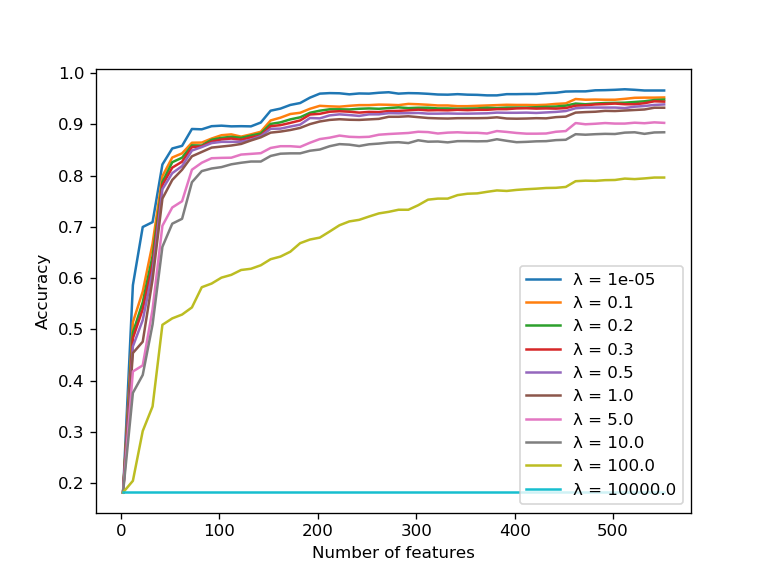

Text(0, 0.5, 'Accuracy')

In [55]:
%matplotlib notebook
for i in range(0,len(regularisations)):
    plt.plot(features_to_test + 1, result[i,:], label='λ = ' + str(regularisations[i]))
    plt.legend()

plt.xlabel('Number of features')
plt.ylabel('Accuracy')

#plt.savefig('figures/regularisations.png')

In [4]:
results = np.zeros([5, len(features_to_test)])

for j in range(0,len(features_to_test)):
    
    print(j)
    
    n_features = features_to_test[j]
    
    features = np.arange(0, n_features)
    Xtrn = X_train[:, features]
    Xtst = X_test[:, features]
    
    line_number = np.arange(1, 6)
    for number in line_number:
        if n_features > 5:
            transformer = LinearDiscriminantAnalysis(n_components = number).fit(Xtrn, y_train)
            Xtrn_transformed = transformer.transform(Xtrn)
            Xtst_transformed = transformer.transform(Xtst)

            y_pred = LDA(Xtrn_transformed, y_train, Xtst_transformed, y_test, 0.00001)
            results[number-1, j] = accuracy_score(y_test, y_pred)

print(results)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
[[0.         0.4282321  0.45334238 0.4499491  0.61655921 0.62436376
  0.59755684 0.62266712 0.63386495 0.65083135 0.64200882 0.63352562
  0.62911435 0.62198846 0.62572107 0.62029182 0.63250763 0.62911435
  0.62130981 0.61859518 0.61723787 0.5911096  0.59619952 0.59857482
  0.60536138 0.6067187  0.59891415 0.60264676 0.60536138 0.59993213
  0.59518154 0.59077027 0.58907363 0.58975229 0.5934849  0.59518154
  0.59518154 0.60298609 0.59721751 0.60128945 0.60298609 0.59925348
  0.59755684 0.59959281 0.59891415 0.59721751 0.5934849  0.5934849
  0.6019681  0.60705803 0.61045131 0.60332542 0.60739735 0.60400407
  0.60332542 0.60027146]
 [0.         0.5127248  0.48150662 0.57108924 0.68680014 0.67492365
  0.62775704 0.64608076 0.65558195 0.66440448 0.66135053 0.65999321
  0.65049203 0.64811673 0.66033254 0.65761792 0.65795724 0.65829657
  

In [2]:
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for number in range(1,6):
    ax.plot(features_to_test, results[number-1,:], '-', label='Comp = ' + str(number))
    ax.legend()

#ax.set_xscale('log')

plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.savefig('figures/transformed_lda_results.png')

np.max(results, axis=1)

<IPython.core.display.Javascript object>

NameError: name 'features_to_test' is not defined

In [57]:
features = np.arange(0,p)

number_samples = np.unique(np.floor(7.352*10**np.linspace(0,3,100))).astype(int)

print(number_samples[0])

results = np.zeros(len(number_samples))

for i in range(0, len(number_samples)):
    sample_test = number_samples[i]
    print(sample_test)
    
    rand_perm = np.random.permutation(N)
    indices = rand_perm[0:sample_test]
    
    Xtrn = X_train[indices]
    ytrn = y_train[indices]
    transformer = LinearDiscriminantAnalysis().fit(Xtrn, ytrn)
    
    Xtrn_transformed = transformer.transform(Xtrn)
    Xtst_transformed = transformer.transform(X_test)
    
    y_pred = LDA(Xtrn_transformed, ytrn, Xtst_transformed, y_test, 0.001)
    results[i] = accuracy_score(y_test, y_pred)


7
7
8
9
10
11
12
13
14
15
16
18
19
20
22
24
25
27
29
31
34
36
39
42
45
48
51
55
59
63
68
73
78
84
90
97
104
111
119
128
137
147
158
169
182
195
209
224
240
258
276
296
318
341
365
392
420
451
483
518
556
596
639
685
735
788
845
906
971
1042
1117
1198
1284
1377
1477
1583
1698
1821
1952
2093
2245
2407
2581
2767
2968
3182
3412
3659
3923
4207
4511
4837
5186
5561
5963
6394
6856
7352


<IPython.core.display.Javascript object>


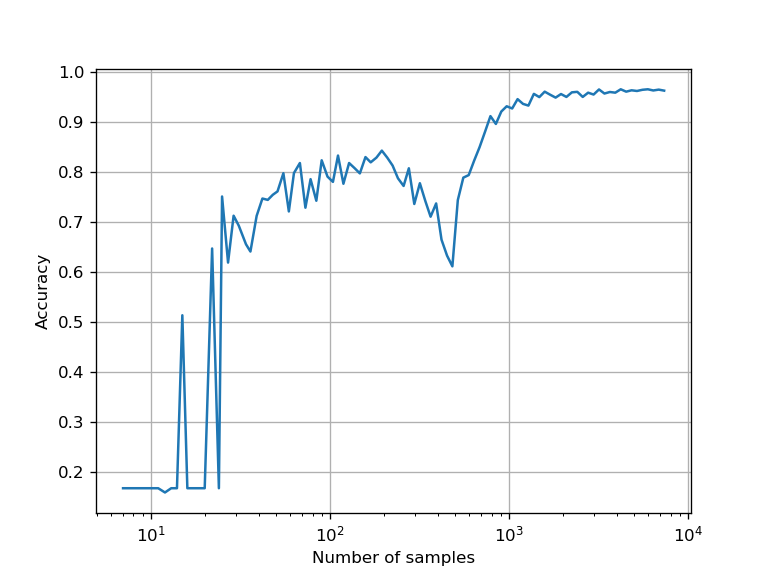

In [61]:
results

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(number_samples, results)
ax.set_xscale('log')
plt.xlabel('Number of samples')
plt.ylabel('Accuracy')
ax.grid()
plt.savefig('low_samples_transformed.png')

In [111]:
N

7352